установим все необходимые библиотеки

In [ ]:
!pip install python-graphblas[default]
!pip install metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
import graphblas as gb
from metagraph import concrete_algorithm, NodeID
from metagraph.plugins import has_grblas
from metagraph.plugins.core import exceptions
from typing import Tuple, Iterable, Any, Union, Optional
import numpy as np

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread

Скачаем 10 графов в формате Matrix Market с сайта SuiteSparse Matrix Collection

In [73]:
M1 = mmread('/content/sample_data/Untitled Folder/Erdos02.mtx')
M2 = mmread('/content/sample_data/Untitled Folder/Erdos972.mtx')
M3 = mmread('/content/sample_data/Untitled Folder/Erdos982.mtx')
M4 = mmread('/content/sample_data/Untitled Folder/Erdos992.mtx')
M5 = mmread('/content/sample_data/Untitled Folder/delaunay_n11.mtx')#/content/sample_data/Untitled Folder/ca-AstroPh.mtx
M6 = mmread('/content/sample_data/Untitled Folder/ca-CondMat.mtx')
M7 = mmread('/content/sample_data/Untitled Folder/delaunay_n13.mtx')
M8 = mmread('/content/sample_data/Untitled Folder/delaunay_n14.mtx')
M9 = mmread('/content/sample_data/Untitled Folder/delaunay_n12.mtx')#/content/sample_data/Untitled Folder/dblp-2010.mtx
M10 = mmread('/content/sample_data/Untitled Folder/delaunay_n15.mtx')

Попробовала визуилизировать каждый из них, что-то страшное:)

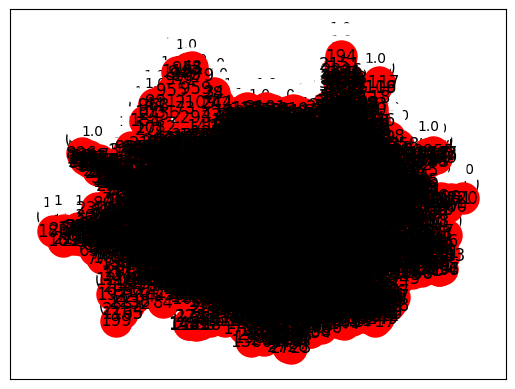

In [ ]:
gb.viz.draw(M1)

Но что-нибудь визуализировать я смогла

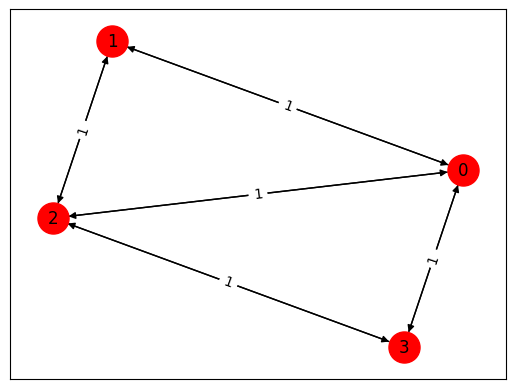

In [ ]:
G = Matrix.from_coo(
    [0, 1, 2, 0, 1, 2, 0, 3, 3, 2],
    [1, 0, 0, 2, 2, 1, 3, 0, 2, 3],
    [1, 1, 1, 1, 1,1, 1, 1, 1, 1],
    nrows=10,
    ncols=10
)
gb.viz.draw(G)

* Используя python-graphblas реализовать наивный алгоритм, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.
 Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 Функция возвращает число --- количество треугольников в графе.
* Используя python-graphblas реализовать наивный алгоритм с маской, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.
 Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 Функция возвращает число --- количество треугольников в графе.
* Используя python-graphblas реализовать Сohen's algorithm, вычисляющий количество треугольников неориентированного графа.
 Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 Функция возвращает число --- количество треугольников в графе.
* Используя python-graphblas реализовать Sandia algorithm, вычисляющий количество треугольников неориентированного графа.
 Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 Функция возвращает число --- количество треугольников в графе.

In [68]:
def naive_triangle_count(A):
    A3=A.mxm(A.mxm(A)) # возведем матрицу в куб
    result=A3.diag().reduce(gb.agg.sum).value or 0 #берем диагональ(след)
    return int(result / 6)

def naiveMaskA2(A):
    A3=A.mxm(A) #возведем матрицу в квадрат
    result=A3.dup(mask=A.dup(dtype=dtypes.BOOL)).reduce_scalar(gb.monoid.plus).value or 0 #применяем маску
    return int(result / 6)

#эти два варианта подсчетов прям по алгоритму
def cohen(A):
    L=gb.select.tril(A)#нижняя треугольная матрица
    U=gb.select.triu(A)#верхняя
    B=L.mxm(U)
    C=B.dup(mask=A.dup(dtype=dtypes.BOOL))
    t=int(C.reduce_scalar(gb.monoid.plus).value or 0)/2
    return t

def sandia(A):
    L=gb.select.tril(A)#нижняя треугольная матрица
    B=L.mxm(L)
    C=B.dup(mask=L.dup(dtype=dtypes.BOOL))
    t=int(C.reduce_scalar(gb.monoid.plus).value or 0)
    return t

In [70]:
def test(A):
    result = [naive_triangle_count(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(element == element for element in result):
       print("All return values are not equal")
    else:
        %timeit naive_triangle_count(A)
        %timeit naiveMaskA2(A)
        %timeit cohen(A)
        %timeit sandia(A)
#test(M1)

In [74]:
test(M2)

[1500, 1500, 1500.0, 1500]
50.9 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.56 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.23 ms ± 983 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.19 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M3)

[1595, 1595, 1595.0, 1595]
38 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.04 ms ± 844 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.02 ms ± 826 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.13 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M4)

[1610, 1610, 1610.0, 1610]
38.9 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.02 ms ± 862 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.08 ms ± 830 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.27 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M5)

[4104, 4104, 4104.0, 4104]
13.1 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.17 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.89 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.29 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M6)

[174692, 174692, 175335.0, 176063]
1.34 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
35.6 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.6 ms ± 8.62 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.5 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M7)

[16442, 16442, 16442.0, 16442]
22.1 ms ± 986 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.84 times longer than the fastest. This could mean that an intermediate result is being cached.
9.25 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.86 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.22 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M8)

[32921, 32921, 32921.0, 32921]
The slowest run took 5.56 times longer than the fastest. This could mean that an intermediate result is being cached.
95.3 ms ± 70.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.5 ms ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.42 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
7.18 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test(M9)

[8215, 8215, 8215.0, 8215]
15.7 ms ± 8.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.31 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.14 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.96 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test(M10)

[65872, 65872, 65872.0, 65872]
113 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
50.5 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.1 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.8 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Вывод:** вообще по хорошему тону математики надо бы сделать усреднение по 12 запускам, но тут и так всё шикарно видно.
Хуже всего по времени сеья показал самый наивный способ, для каждого графа считал очень медленно, на втором месте по "медленности" - наивный способ с маской
и самый шустрый во всех случаях получился Sandia algorithm

* Используя python-graphblas реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.
 Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 Функция возвращает массив, где для каждой вершины указано, в скольки треугольниках она участвует.

Для решения этой задачи первым делом пришла такая идея: взять наивный подсчет треугольников, и след матрицы поделить на 2. **готово**

In [ ]:
def v_count(A):
    A3=A.mxm(A.mxm(A))
    result = A3.diag().apply(lambda x: x//2)
    return result
v_count(G)

gb.VectorExpression                  size  dtype
v_1145.apply(unary.<lambda>[INT64])    10  INT64

"Result"   nvals  size  dtype
gb.Vector      4    10  INT64
-----------------------------
index  0  1  2  3 4 5 6 7 8 9
value  2  1  2  1            

Do expr.new() or other << expr to calculate the expression.

то есть у вершины ноль 2 треугольника, у вершины с индексом 1 - 1 треугольник и так далее

* Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа. Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости. Сделать выводы.

Степень разреженности - nonzeros - количество ненулевых элементов в матрице смежности

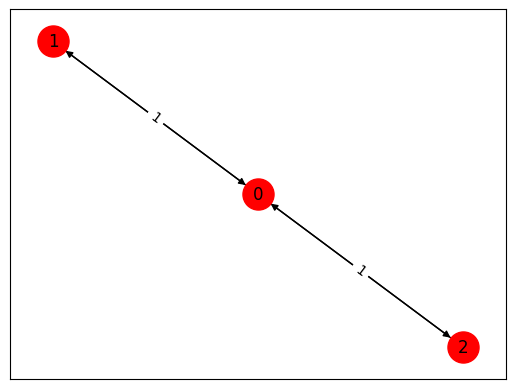

"M_91"     nvals  nrows  ncols  dtype         format
gb.Matrix      4      3      3  INT64  bitmapr (iso)
----------------------------------------------------
   0  1  2
0     1  1
1  1      
2  1      
Time taken to create a graph with 100 vertices and sparsity 99 is 0.01980733871459961s
Time taken to create a graph with 100 vertices and sparsity 1 is 0.00034546852111816406s
Time taken to create a graph with 100 vertices and sparsity 50 is 0.009175300598144531s
Time taken to create a graph with 1000 vertices and sparsity 999 is 0.1477038860321045s
Time taken to create a graph with 1000 vertices and sparsity 1 is 0.0006873607635498047s
Time taken to create a graph with 1000 vertices and sparsity 500 is 0.07701396942138672s
Time taken to create a graph with 5000 vertices and sparsity 4999 is 1.3736228942871094s
Time taken to create a graph with 5000 vertices and sparsity 1 is 0.0008237361907958984s
Time taken to create a graph with 5000 vertices and sparsity 2500 is 0.6040425300598145s


In [ ]:
from time import time
import random

def generate_random_graph(n, fill_count):
    # n -количество вершин, fill_count - степень разреженности
    m = gb.Matrix(int, n, n) #пустая матрица
    while fill_count > 0:
        i = random.randint(0, n-1)
        j = random.randint(0, n-1)
        if m.get(i,j) is None and i!= j: #если не пустое место, то ставим симметричную 1
            m[i,j] = 1
            m[j,i] = 1
            fill_count -= 1
    return m
m = generate_random_graph(3,2)
gb.viz.draw(m)
print(m)


sizes = [100,1000, 5000, 10000, 99999]

for size in sizes:
  sparsities = [size - 1, 1, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
        start = time()
        m = generate_random_graph(size, sparsity)
        print(f"Time taken to create a graph with {size} vertices and sparsity {sparsity} is {time() - start}s")


In [71]:


sizes = [100,1000, 5000, 10000, 99999]

for size in sizes:
  sparsities = [size - 1, 1, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
        start = time()
        test(generate_random_graph(size, sparsity))
        print(f"Time {size} vertices and sparsity {sparsity} is {time() - start}s")



[1, 1, 1.0, 1]
312 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
182 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
420 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
331 µs ± 140 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time taken to create a graph with 100 vertices and sparsity 99 is 24.25016164779663s
[0, 0, 0.0, 0]
198 µs ± 8.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
169 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
316 µs ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
227 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time taken to create a graph with 100 vertices and sparsity 1 is 20.2457115650177s
[0, 0, 0.0, 0]
254 µs ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
259 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
300 µs ± 8.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

In [75]:
sizes = [100,1000, 5000, 10000, 99999]

for size in sizes:
  sparsities = [size - 1, 10, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
        start = time()
        test(generate_random_graph(size, sparsity))
        print(f"Time {size} vertices and sparsity {sparsity} is {time() - start}s")

[2, 2, 2.0, 2]
314 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
179 µs ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
311 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
213 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time 100 vertices and sparsity 99 is 23.34737539291382s
[0, 0, 0.0, 0]
212 µs ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
156 µs ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
413 µs ± 89.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
232 µs ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time 100 vertices and sparsity 10 is 36.44877052307129s
[0, 0, 0.0, 0]
222 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
165 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
296 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
200 µs ± 7.55 µs per loop (mean ± std. dev. of 7 

Вывод:

Для неразреженных матриц хуже всего наивный и Сohen's algorithm, лучше всего наивный с маской, и чуть похуже, но также хорош - Sandia algorithm

Для разреженных матриц: лучше всего наивный с маской, худший - Сohen's algorithm
